# Modelo inicial (XGBoost)

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, classification_report,
precision_score, recall_score, f1_score, roc_auc_score, roc_curve)

from xgboost import XGBClassifier

## Data Import

In [2]:
data = pd.read_csv('../data/processed/adult.data')

In [3]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

### Train-Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Model Training

In [5]:
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## Model Evaluation

In [6]:
y_pred = classifier.predict(X_test)
y_proba = classifier.predict_proba(X_test)[:, 1]

In [7]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8988    0.9485    0.9230      7416
           1     0.8028    0.6625    0.7260      2347

    accuracy                         0.8798      9763
   macro avg     0.8508    0.8055    0.8245      9763
weighted avg     0.8757    0.8798    0.8756      9763



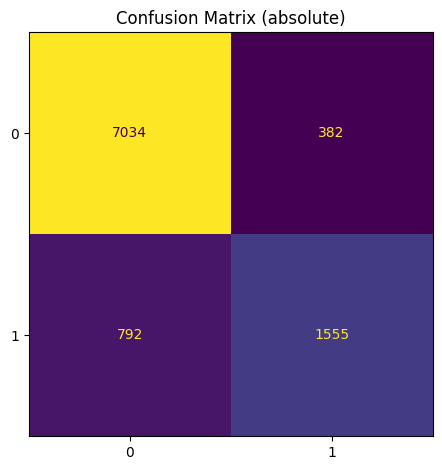

In [8]:
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot(ax=ax, colorbar=False)
ax.set(xlabel=None, ylabel=None)
ax.set_title("Confusion Matrix (absolute)")
plt.tight_layout()
plt.show()

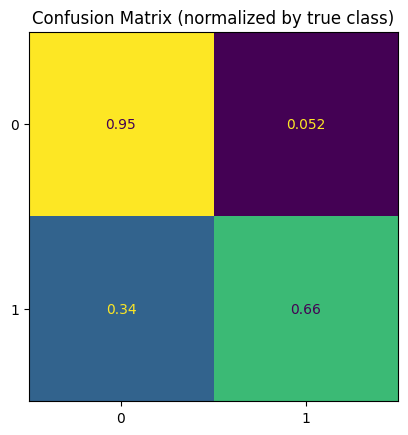

In [9]:
fig, ax = plt.subplots()
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(cm_norm)
disp.plot(ax=ax, colorbar=False)
ax.set(xlabel=None, ylabel=None)
plt.title("Confusion Matrix (normalized by true class)")
plt.show()

## Model Evaluation by Sensitive Groups

In [10]:
_, dataset = train_test_split(data, test_size=0.2, random_state=0)
dataset = dataset.reset_index(drop=True)

In [11]:
dataset["gender"] = np.where(dataset["sex_Male"] == 1, "Male", "Female")

dataset["race"] = np.where(
    dataset["race_White"] == 1, "White",
    np.where(dataset["race_Other"] == 1, "Other", "Unknown")
)

bins_age = [0, 29, 44, 59, 120]
labels_age = ["<30", "30-44", "45-59", "60+"]
dataset["age_bin"] = pd.cut(
    dataset["age"], bins=bins_age, labels=labels_age, include_lowest=True
)

In [12]:
def metrics_by_group(df, group_col, y_true, y_pred, y_score):
    rows = []
    for g, idx in df.groupby(group_col, observed=True).groups.items():
        yt = y_true[idx]; yp = y_pred[idx]; ys = y_score[idx]
        tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()
        sel_rate = (yp == 1).mean()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        prev = yt.mean()
        try:
            auc = roc_auc_score(yt, ys)
        except ValueError:
            auc = np.nan
        rows.append({
            group_col: g,
            "n": len(yt),
            "real_rate": prev,
            "predicted_rate": sel_rate,
            "TPR": tpr,
            "FPR": fpr,
            "precision": precision_score(yt, yp, zero_division=0),
            "recall": recall_score(yt, yp, zero_division=0),
            "f1": f1_score(yt, yp, zero_division=0),
            "AUC": auc
        })
    out = pd.DataFrame(rows).sort_values("n", ascending=False).reset_index(drop=True)
    return out

In [13]:
def plot_rates(rep, group_col, title):
    x = np.arange(len(rep))
    width = 0.38
    _, ax = plt.subplots()
    b1 = ax.bar(x - width/2, rep["real_rate"].values, width, label="Real")
    b2 = ax.bar(x + width/2, rep["predicted_rate"].values, width, label="Predicted")
    ax.set_xticks(x)
    ax.set_xticklabels(rep[group_col].astype(str).tolist(), rotation=0)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Proportion")
    ax.set_title(title)
    ax.legend()
    for b in [b1, b2]:
        ax.bar_label(b, labels=[f"{v:.2f}" for v in b.datavalues], padding=3)
    plt.show()

In [14]:
def plot_roc_by_group(df, group_col, y_true, y_score, title):
    _, ax = plt.subplots()
    for g, idx in df.groupby(group_col, observed=True).groups.items():
        yt = y_true[idx]; ys = y_score[idx]
        if len(np.unique(yt)) < 2:
            continue
        fpr, tpr, _ = roc_curve(yt, ys)
        auc_val = roc_auc_score(yt, ys)
        ax.plot(fpr, tpr, label=f"{g} (AUC={auc_val:.3f})")
    ax.plot([0,1],[0,1], label="Random")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_title(title)
    ax.legend(loc="lower right")
    plt.show()

In [15]:
rep_sexo = metrics_by_group(dataset, "gender", y_test, y_pred, y_proba)
rep_raza = metrics_by_group(dataset, "race", y_test, y_pred, y_proba)
rep_edad = metrics_by_group(dataset, "age_bin", y_test, y_pred, y_proba)

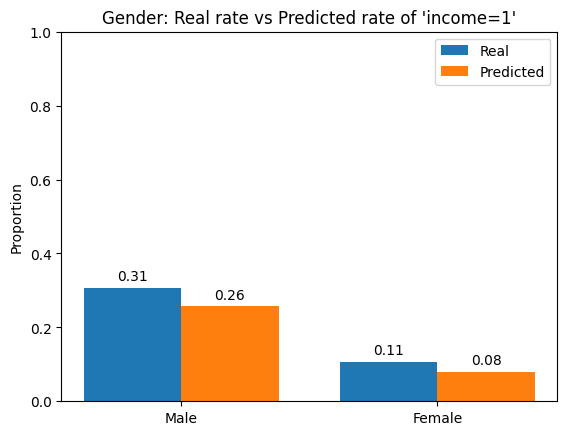

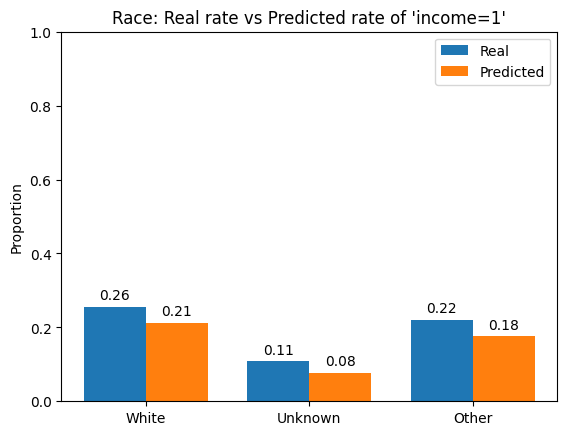

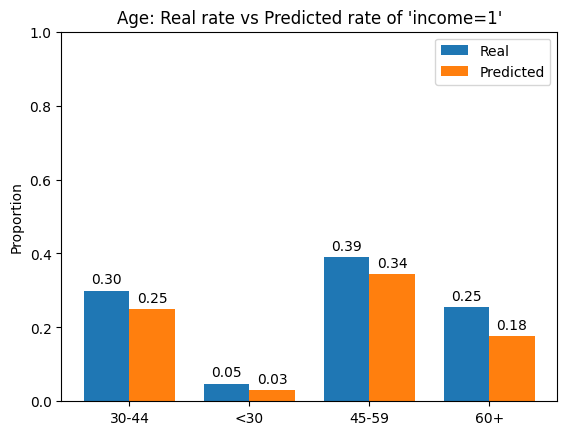

In [16]:
plot_rates(rep_sexo, "gender", "Gender: Real rate vs Predicted rate of 'income=1'")
plot_rates(rep_raza, "race", "Race: Real rate vs Predicted rate of 'income=1'")
plot_rates(rep_edad, "age_bin", "Age: Real rate vs Predicted rate of 'income=1'")

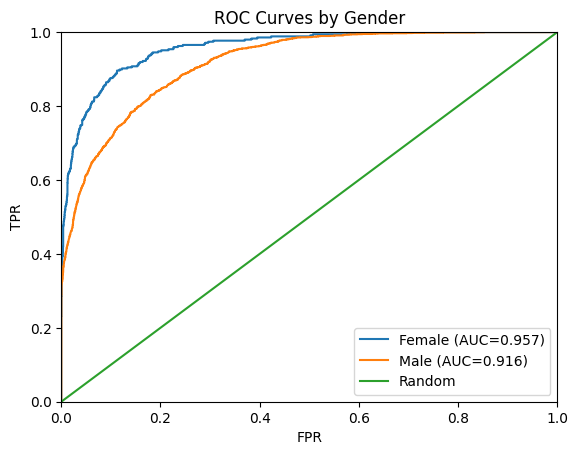

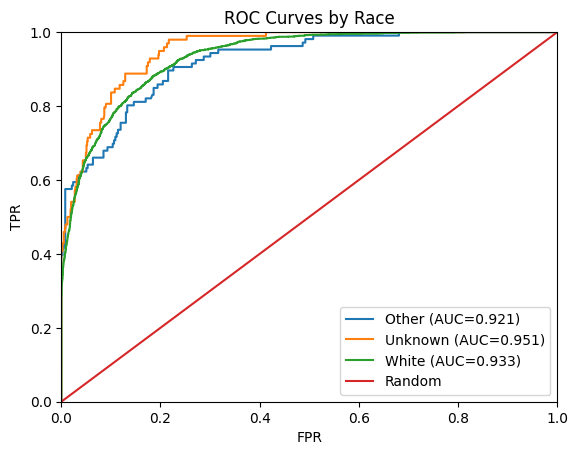

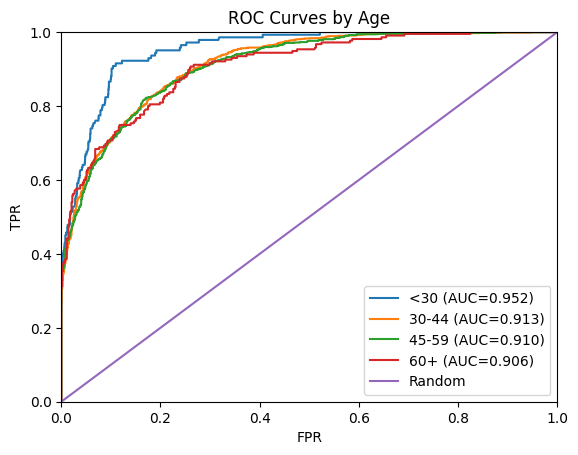

In [17]:
plot_roc_by_group(dataset, "gender", y_test, y_proba, "ROC Curves by Gender")
plot_roc_by_group(dataset, "race", y_test, y_proba, "ROC Curves by Race")
plot_roc_by_group(dataset, "age_bin", y_test, y_proba, "ROC Curves by Age")